In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

In [2]:
games = pd.read_csv("games.csv")
del games['created_at']
del games['last_move_at']

In [4]:
elo_w = games['white_rating']
elo_b = games['black_rating']
average_rating = np.round((np.mean(elo_w)+np.mean(elo_b))/2,2)
median_rating = (np.median(elo_w)+np.median(elo_b))/2

# Caclul du nombre total de joueurs différents
id_players = np.hstack((np.array(games['black_id']),np.array(games['white_id'])))
id_player = np.unique(id_players)

# Création de la colonne diff_élo qui permettra de comparer plus tard le pourcentage de victoires en fonction de la différence d'élo des joueurs
print("Nombre total de parties : ",games.shape[0])
print("Nombre total de joueurs différents :",id_player.size)

# l'élo n'étant pas fix au court du temps on peut se permettre de prendre plusieurs classements élos du même joueur

print("Moyenne du classement élo des joueurs sur chaque partie :",average_rating)
print("Médiane du classement élo des joueurs sur chaque partie :",median_rating)
print("Classement élo maximum :",np.max([elo_w,elo_b]))

Nombre total de parties :  20058
Nombre total de joueurs différents : 15635
Moyenne du classement élo des joueurs sur chaque partie : 1592.73
Médiane du classement élo des joueurs sur chaque partie : 1564.5
Classement élo maximum : 2723


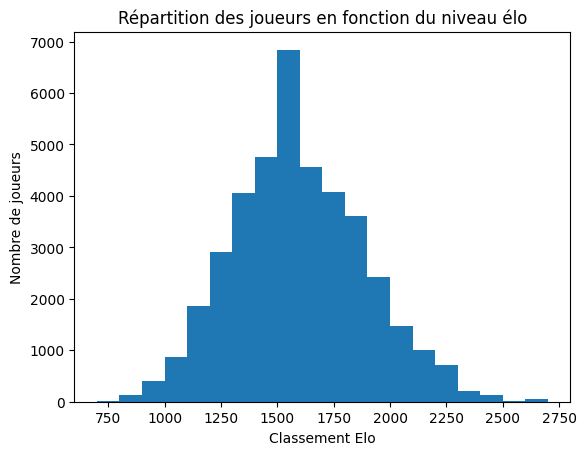

In [16]:
# Visualisation des données sous la forme de graphiques
elo = np.hstack((elo_w,elo_b))
plt.hist(elo,bins=range(700,2800,100))
plt.title("Répartition des joueurs en fonction du niveau élo");
plt.xlabel("Classement Elo");
plt.ylabel("Nombre de joueurs");

In [31]:
#PQ AUTANT DE JOUEURS AUTOUR DE 1500 ELOS
elo_1500 = np.size(elo_w[(elo_w>=1400)&(elo_w<=1600)]) + np.size(elo_b[(elo_b>=1400)&(elo_b<=1600)])
print("Pourcentage de joueurs entre 1400 et 1600 élo : ",np.round(elo_1500/20058*100,2),"%")
elo_1500 = np.size(elo_w[(elo_w==1500)]) + np.size(elo_b[(elo_b==1500)])
print("Pourcentage de joueurs à exactemet 1500 élo : ",np.round(elo_1500/20058*100,2),"%")

Pourcentage de joueurs entre 1400 et 1600 élo :  58.15 %
Pourcentage de joueurs à exactemet 1500 élo :  8.02 %


Nb. victoires blancs : 10001 
N.b victoires énoirs : 9107 
match nul : 950


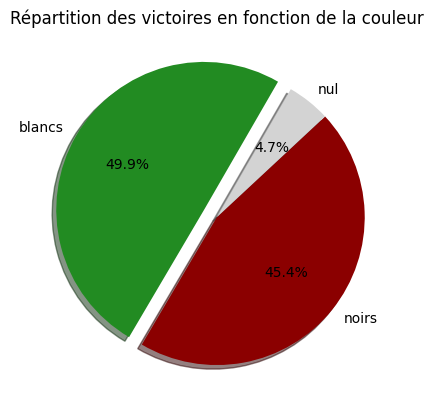

In [40]:
# VISUALISATION DES POURCENTAGES DE VICTOIRE EN FONCTION DE LA COULEUR

w_white = games[games['winner'] == 'white'].shape[0]
w_black = games[games['winner'] == 'black'].shape[0]
draw = games[games['winner']=='draw'].shape[0]
labels = 'blancs','noirs','nul'
fig, ax = plt.subplots()
ax.pie([w_white,w_black,draw],explode=(0.1, 0, 0), labels=labels, autopct='%1.1f%%',colors=['forestgreen','darkred','lightgrey'],shadow=True, startangle=60)
plt.title("Répartition des victoires en fonction de la couleur");
print("Nb. victoires blancs :",w_white,"\nN.b victoires énoirs :",w_black,"\nmatch nul :",draw)

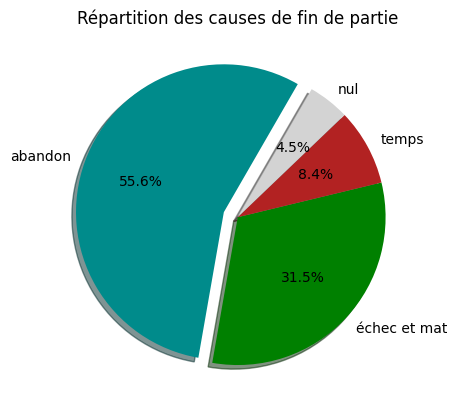

In [7]:
# Visualisation des raisons de défaite
res = games[games['victory_status']== 'resign'].shape[0]
mate = games[games['victory_status']== 'mate'].shape[0]
tim = games[games['victory_status']== 'outoftime'].shape[0]
draw = games[games['victory_status']== 'draw'].shape[0]
labels2 = 'abandon','échec et mat','temps','nul'
fig, ax = plt.subplots()
ax.pie([res,mate,tim,draw], labels=labels2, autopct='%1.1f%%',shadow=True,explode = (0.1, 0, 0,0),startangle=60,colors=['darkcyan','green','firebrick','lightgrey'])
plt.title("Répartition des causes de fin de partie");

In [80]:
games['diff_elo'] = games['white_rating'] - games['black_rating']
#Notons alors que la différence d'élo est supérieur à 0 si les blancs ont un élo supérieur à celui des noirs et est négative si les noirs ont un élo supérieur à celui des blancs

Nb victoires élo supérieur : 12352 
Nb victoires élo inférieur : 6566 
match nul : 950 
 total : 20058


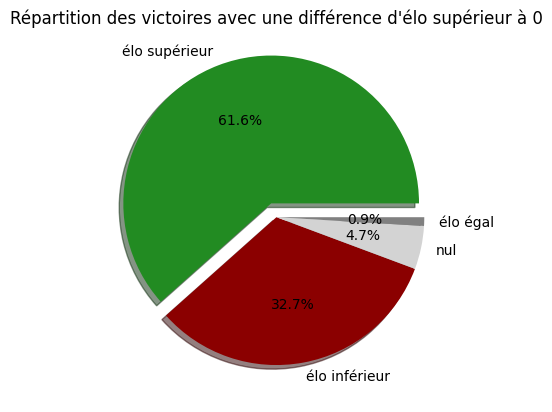

In [86]:
m = 0
adv = games[(games['winner']=='white')&(games['diff_elo']>m)].shape[0]
adv += games[(games['winner']=='black')&(games['diff_elo']<-m)].shape[0]
dis = games[(games['winner']=='black')&(games['diff_elo']>m)].shape[0]
dis += games[(games['winner']=='white')&(games['diff_elo']<-m)].shape[0]
equ = games[(games['winner']=='black')&(games['diff_elo']==m)].shape[0]
equ += games[(games['winner']=='white')&(games['diff_elo']==m)].shape[0]
draw = games[(games['winner']=='draw')&(games['diff_elo']<-m)].shape[0]
draw += games[(games['winner']=='draw')&(games['diff_elo']>=m)].shape[0]
fig, ax = plt.subplots()
labels3 = 'élo supérieur','élo inférieur','nul','élo égal'
ax.pie([adv,dis,draw,equ], labels=labels3, autopct='%1.1f%%',shadow=True,explode=(0.1,0,0,0),colors=['forestgreen','darkred','lightgrey','grey'])
plt.title("Répartition des victoires avec une différence d'élo supérieur à 0");
print("Nb victoires élo supérieur :",adv,"\nNb victoires élo inférieur :",dis,"\nmatch nul :",draw,"\ntotal :",draw+adv+dis+equ)

Nb victoires élo supérieur : 7762 
Nb victoires élo inférieur : 2725 
Nb match nul : 464 
Nb total de parties : 10951


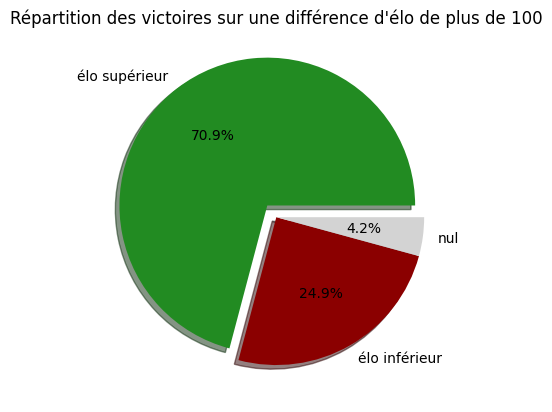

In [91]:
# Cas de différence d'élos

m = 100
adv = games[(games['winner']=='white')&(games['diff_elo']>=m)].shape[0]
adv += games[(games['winner']=='black')&(games['diff_elo']<=-m)].shape[0]
dis = games[(games['winner']=='black')&(games['diff_elo']>=m)].shape[0]
dis += games[(games['winner']=='white')&(games['diff_elo']<=-m)].shape[0]
draw = games[(games['winner']=='draw')&(games['diff_elo']<=-m)].shape[0]
draw += games[(games['winner']=='draw')&(games['diff_elo']>=m)].shape[0]
fig, ax = plt.subplots()
labels3 = 'élo supérieur','élo inférieur','nul'
ax.pie([adv,dis,draw], labels=labels3, autopct='%1.1f%%',shadow=True,explode=(0.1,0,0),colors=['forestgreen','darkred','lightgrey'])
plt.title("Répartition des victoires sur une différence d'élo de plus de 100");
print("Nb victoires élo supérieur :",adv,"\nNb victoires élo inférieur :",dis,"\nNb match nul :",draw,"\nNb total de parties :",draw+adv+dis)

Nb victoires élo supérieur : 56 
Nb victoires élo inférieur : 5 
Nb match nul : 1 
Nb total de parties : 62


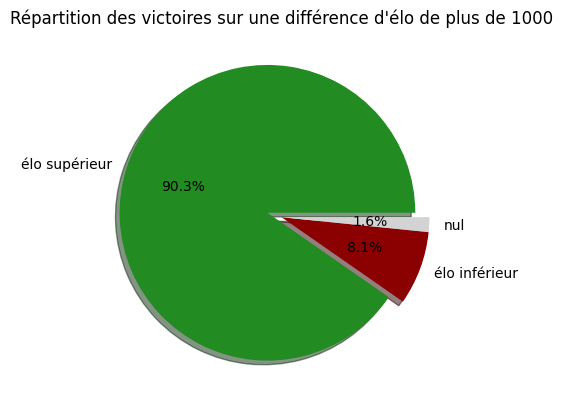

In [90]:
# Cas de différence d'élos absurde

m = 1000
adv = games[(games['winner']=='white')&(games['diff_elo']>=m)].shape[0]
adv += games[(games['winner']=='black')&(games['diff_elo']<=-m)].shape[0]
dis = games[(games['winner']=='black')&(games['diff_elo']>=m)].shape[0]
dis += games[(games['winner']=='white')&(games['diff_elo']<=-m)].shape[0]
draw = games[(games['winner']=='draw')&(games['diff_elo']<=-m)].shape[0]
draw += games[(games['winner']=='draw')&(games['diff_elo']>=m)].shape[0]
fig, ax = plt.subplots()
labels3 = 'élo supérieur','élo inférieur','nul'
ax.pie([adv,dis,draw], labels=labels3, autopct='%1.1f%%',shadow=True,explode=(0.1,0,0),colors=['forestgreen','darkred','lightgrey'])
plt.title("Répartition des victoires sur une différence d'élo de plus de 1000");
print("Nb victoires élo supérieur :",adv,"\nNb victoires élo inférieur :",dis,"\nNb match nul :",draw,"\nNb total de parties :",draw+adv+dis)